In [2]:
import numpy as np
from tqdm.notebook import tqdm, trange
from alive_progress import alive_bar
import time # to be used in loop iterations
import caffeine
from multiprocess import Pool
import matplotlib.pyplot as plt
from queue import Queue
from threading import Thread
np.random.seed(1234)

# Isotropic Gaussian non-monotone activation

I implemented a single layer neural network with a non-monotone activcation function and trained in on jointly Bernoulli and isotropic Gaussian data constructed in the 2018 paper by Mei et al. entitled 'A mean field view of the landscape of two-layer neural networks' using stochastic gradient descent. I studied limiting properties of the evolution of the network parameters, treated as interacting particles and made comparisons in monitoring losses incurred by the discretised SGD algorithm and the distributional dynamics introduced in the paper. I also modified the training algorithm using Nesterov's method to see if the bad local minimum is avoided as opposed to vanilla SGD which got stuck.

## SGD dynamics

In [3]:
#Ground truth data distribution
def random_sample(d, Delta, N):
    """
    Generate random samples from a ground truth data distribution.

    Parameters:
        d (int): The dimensionality of the data.
        Delta (float): A parameter controlling the spread of the data distribution.
        N (int): The number of samples to generate.

    Returns:
        tuple: A tuple containing two arrays (x, y).
            - x (numpy.ndarray): Input data samples with shape (N, d).
            - y (numpy.ndarray): Corresponding labels or target values with shape (N,).
    """
    y = np.ones(N)
    x = np.zeros((N,d))
    successes = np.random.binomial(N, 0.5)
    y[successes:] *= -1
    x[:successes, :] = np.random.multivariate_normal([0]*d, np.diag([(1+Delta)**2]*d), successes)
    x[successes:, :] = np.random.multivariate_normal([0]*d, np.diag([(1-Delta)**2]*d), N-successes)
    
    return x.reshape(N,d),y

In [4]:
#non-monotone activation function
def sigma_nm(t):
    if t < 0:
        return -2.5
    elif t>1.5:
        return 7.5
    elif 0<=t<0.5:
        return -3*(t)-2.5
    elif 0.5<=t<=1.5:
        return (11.5)*(t-0.5)-4
        
def grad_sigma_nm(t):
    if t < 0:
        return 0
    elif t>1.5:
        return 0
    elif 0<=t<0.5:
        return -3
    elif 0.5<=t<=1.5:
        return 11.5
vgrad_sigma_nm = np.vectorize(grad_sigma_nm)
vsigma_nm = np.vectorize(sigma_nm)

In [5]:
#two layer neural net with non-monotone activation
def neural_net_nm(x, θ):
    #shape of x: (n,d)
    #shape of theta: (N,d)
    n = x.shape[0]
    out = vsigma_nm(θ@x.T)
    return np.mean(out, axis = 0).reshape(n,1)

In [89]:
def stochastic_gradient_descent(d, Delta, N, kappa, epsilon = 1e-5, num_epochs = 1000):
    """
    Perform stochastic gradient descent to optimize weights for a neural network.

    Parameters:
        d (int): The dimensionality of the data.
        Delta (float): A parameter controlling the spread of the data distribution.
        N (int): The number of weights.
        kappa (float): A parameter controlling the spread of the weight distribution.
        epsilon (float, optional): The learning rate. Default is 1e-5.
        num_epochs (int, optional): The number of training epochs. Default is 1000.

    Returns:
        tuple: A tuple containing the following elements:
            - weights (numpy.ndarray): The optimized weights with shape (N, d).
            - risk (numpy.ndarray): The risk (mean squared error) at each epoch.
            - mean_dist (numpy.ndarray): The mean Euclidean distance of the weights at each epoch.
            - indices (list): List of indices at which risk is recorded.
    """
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), N).reshape(N, d)
    indices = [1,2,5]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 30))]
    risk = []
    mean_dist = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        sample = random_sample(d,Delta,1)
        x = sample[0].reshape(1,d)
        y = sample[1]
        grad = vgrad_sigma_nm(weights@x.T).reshape(N,1)*x
        step = epsilon*(epsilon*epoch)**(-0.25)
        weights += 2*step*(y.reshape(-1,1)-neural_net_nm(x, weights))*grad
        if epoch in indices:
        #population risk
            M = int(1e4)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample.reshape(-1,1)-neural_net_nm(x_sample,weights))**2)
            risk.append(mse)
            dist = np.mean(np.linalg.norm(weights, axis = 1))
            mean_dist.append(dist)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_dist, indices

In [164]:
def Nesterov_stochastic_gradient_descent(d, Delta, N, kappa, epsilon = 1e-5, r = 3, num_epochs = 1000):
    """
    Perform Nesterov accelerated stochastic gradient descent to optimize weights for a neural network.

    Parameters:
        d (int): The dimensionality of the data.
        Delta (float): A parameter controlling the spread of the data distribution.
        N (int): The number of weights.
        kappa (float): A parameter controlling the spread of the weight distribution.
        epsilon (float, optional): The learning rate. Default is 1e-5.
        r (int, optional): The acceleration factor for Nesterov momentum. Default is 3.
        num_epochs (int, optional): The number of training epochs. Default is 1000.

    Returns:
        tuple: A tuple containing the following elements:
            - weights (numpy.ndarray): The optimized weights with shape (N, d).
            - risk (numpy.ndarray): The risk (mean squared error) at each epoch.
            - mean_dist (numpy.ndarray): The mean Euclidean distance of the weights at each epoch.
            - indices (list): List of indices at which risk is recorded.
    """
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), N).reshape(N, d)
    weights_change = weights
    
    indices = [1,2,5]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 30))]
    risk = []
    mean_dist = []
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        sample = random_sample(d,Delta,1)
        x = sample[0].reshape(1,d)
        y = sample[1]
        grad = vgrad_sigma_nm(weights_change@x.T).reshape(N,1)*x
        step = epsilon*(epsilon*epoch)**(-0.25)
        w1 = weights
        weights_new = weights_change + 2*step*(y-neural_net_nm(x, weights_change))*grad
        weights_change = weights_new + 0.99*(weights_new-w1)
        weights = weights_new
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample.reshape(-1,1)-neural_net_nm(x_sample,weights))**2)
            risk.append(mse)
            dist = np.mean(np.linalg.norm(weights, axis = 1))
            mean_dist.append(dist)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_dist, indices

In [69]:
def Hom_SGLD(d, Delta, N, kappa = 0.1, M = 10, λ = 10, epsilon = 1e-5, num_epochs = 1000):
    """
    Perform Homogeneous Stochastic Gradient Langevin Dynamics (Hom-SGLD) to optimize weights for a neural network.

    Parameters:
        d (int): The dimensionality of the data.
        Delta (float): A parameter controlling the spread of the data distribution.
        N (int): The number of weights.
        kappa (float, optional): A parameter controlling the spread of the weight distribution. Default is 0.1.
        M (int, optional): The number of steps in the fast time scale. Default is 10.
        λ (int, optional): Regularization parameter. Default is 10.
        epsilon (float, optional): The learning rate. Default is 1e-5.
        num_epochs (int, optional): The number of training epochs. Default is 1000.

    Returns:
        tuple: A tuple containing the following elements:
            - weights (numpy.ndarray): The optimized weights with shape (N, d).
            - risk (numpy.ndarray): The risk (mean squared error) at each epoch.
    """
    
    indices = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 20))]

    #initialise params
    weights = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), N).reshape(N, d)
    
    #initialise fast time scale variables Y as a numpy matrix with dimensions (num_epochs, N, M)
    Y_w = np.zeros((N, d))
    
    risk = []
    
    for epoch in trange(1, num_epochs+1): 
        
        #sample from data
        x,y = random_sample(d,Delta,1)
        x = x.reshape(1,d)
        
        #update Y
        Y_w_1 = np.zeros((N, d))
        Y_w_1 = Y_w
        
        cal_Y_w = np.zeros((N, d))
        
        for m in range(1,M+1):
            δ = 0.01/20
            γ = 0.1
            β = 10
            f = neural_net_nm(x, Y_w_1.reshape((N,d)))
            dw = vgrad_sigma_nm(Y_w_1.reshape((N,d))@x.T).reshape(N,1)*x
            dw *= 2*(y-f)
                        
            Y_w_1 = Y_w_1 - δ*(dw-(1/γ)*(weights-Y_w_1))\
            + np.sqrt(2*(δ/β))*np.random.normal(0,1,(N,d))
            
            cal_Y_w += Y_w_1
            
        Y_w = Y_w_1
        cal_Y_w /= M
        
        #update model parameters
        Δ = epsilon*(epoch*epsilon)**(-0.25)
        mu = np.mean(weights, axis = 1).reshape(1,N)
        
        weights = weights - 1/γ*(weights-cal_Y_w)*Δ - λ*(weights - mu.T)*Δ
              
        if epoch in indices:
        #population risk
            M = int(1e2)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample.reshape(-1,1)-neural_net_nm(x_sample,weights))**2)
            risk.append(mse)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
                
    return weights, np.array(risk)

In [70]:
def Mass(d,Delta, N, kappa = 0.1, epsilon = 1e-5, num_epochs = 1000):
    """
    Use Mass (Momentum-added Stochastic Solver) to optimize weights for a neural network.

    Parameters:
        d (int): The dimensionality of the data.
        Delta (float): A parameter controlling the spread of the data distribution.
        N (int): The number of weights.
        kappa (float, optional): A parameter controlling the spread of the weight distribution. Default is 0.1.
        epsilon (float, optional): The learning rate. Default is 1e-5.
        num_epochs (int, optional): The number of training epochs. Default is 1000.

    Returns:
        tuple: A tuple containing the following elements:
            - weights (numpy.ndarray): The optimized weights with shape (N, d).
            - risk (numpy.ndarray): The risk (mean squared error) at each epoch.
    """
    
    indices = [int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 30))]
    weights = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), N).reshape(N, d)
    lookahead = weights
    
    risk = []

    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        x,y = random_sample(d,Delta,1)
        x = x.reshape(1,d)
        
        lr = epsilon*(epsilon*epoch)**(-0.25)
        
        vgrad = vgrad_sigma_nm(lookahead@x.T)
        gradient = vgrad.reshape(N,1)*(x).reshape(1,d)
        
        alpha = 0.05
        m = 2
        eta2 = lr/(1+alpha)/m
        
        weights_new = lookahead + 2*epsilon*(y-neural_net_nm(x, lookahead))*gradient
        lookahead = weights_new + 0.5*(weights_new - weights) - \
        eta2*2*(y-neural_net_nm(x, lookahead))*gradient
        #((epoch-1)/(epoch+r-1)), r>=3
    
        weights = weights_new
        
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample.reshape(-1,1)-neural_net_nm(x_sample,weights))**2)
            risk.append(mse)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
                
    return weights, np.array(risk)

In [71]:
def Restarted_Nesterov_sgd(d, Delta, N, kappa, epsilon = 1e-5, r = 3, num_epochs = 1000):
    """
    Perform Restarted Nesterov Stochastic Gradient Descent with lookahead to optimize weights for a neural network.

    Parameters:
        d (int): The dimensionality of the data.
        Delta (float): A parameter controlling the spread of the data distribution.
        N (int): The number of weights.
        kappa (float): A parameter controlling the spread of the weight distribution.
        epsilon (float, optional): The learning rate. Default is 1e-5.
        r (int, optional): The restart parameter. Default is 3.
        num_epochs (int, optional): The number of training epochs. Default is 1000.

    Returns:
        tuple: A tuple containing the following elements:
            - weights (numpy.ndarray): The optimized weights with shape (N, d).
            - risk (numpy.ndarray): The risk (mean squared error) at each epoch.
            - mean_dist (numpy.ndarray): The mean Euclidean distance of weight vectors from the origin.
            - indices (list): A list of epoch indices where risk is recorded.
    """
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), N).reshape(N, d)
    weights_change = weights
    
    indices = [1,2,5]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 30))]
    risk = []
    mean_dist = []
    count = 1
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        sample = random_sample(d,Delta,1)
        x = sample[0].reshape(1,d)
        y = sample[1]
        grad = vgrad_sigma_nm(weights_change@x.T).reshape(N,1)*x
        step = epsilon*(epsilon*epoch)**(-0.25)
        w1 = weights
        grad = step*(y-neural_net_nm(x, weights_change))*grad
        weights_new = weights_change + 2*grad
        weights_change = weights_new + ((count-1)/(count+r-1))*(weights_new-w1)
        weights = weights_new
        if np.sum((weights_new-w1)*grad) < 0:
                count = 1
        else:
            count += 1
            
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample.reshape(-1,1)-neural_net_nm(x_sample,weights))**2)
            risk.append(mse)
            dist = np.mean(np.linalg.norm(weights, axis = 1))
            mean_dist.append(dist)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
                
    return weights, np.array(risk), mean_dist, indices

In [194]:
def nesterov_heat_gd(d, Delta, N, kappa, epsilon = 1e-5, r = 3, num_epochs = 1000):
    """
    Train a neural network using Nesterov Accelerated Gradient Descent with noise.

    Parameters:
    d (int): Dimensionality of the data.
    Delta (float): Anisotropy factor.
    N (int): Number of neurons in the hidden layer.
    epsilon (float): Learning rate.
    r (int): Parameter for Nesterov acceleration.
    num_epochs (int): Number of training epochs.

    Returns:
    ndarray: Trained weights of the neural network.
    ndarray: Mean squared errors (MSE) at each epoch.
    """
    
    weights = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), N).reshape(N, d)
    weights_change = weights
    
    indices = [1,2,5]+[int(a) for a in 10**(np.linspace(1.1, np.log10(num_epochs), 30))]
    risk = []
    mean_dist = []
    count = 1
    
    for epoch in trange(1, num_epochs+1): 
        # Update the weights
        sample = random_sample(d,Delta,1)
        x = sample[0].reshape(1,d)
        y = sample[1]
        grad = np.zeros((N,d))
        step = epsilon*(epsilon*epoch)**(-0.25)
        w_loc = np.zeros((N,d))
        for i in range(10):
            heat_w = np.random.normal(0,0.5**epoch, w_loc.shape)
            w_loc = weights_change + heat_w
            grad = vgrad_sigma_nm(w_loc@x.T).reshape(N,1)*x  
            
        weights_new = weights_change + 2*step*(y-neural_net_nm(x, weights_change))*grad  
        weights_change = weights_new + ((count-1)/(count+r-1))*(weights_new-weights)  
        if np.sum((weights_new-weights)*grad) < 0:
                count = 1
        else:
            count += 1
        weights = weights_new
        if epoch in indices:
        #population risk
            M = int(1e3)
            x_sample, y_sample = random_sample(d, Delta, M)
            mse = np.mean((y_sample.reshape(-1,1)-neural_net_nm(x_sample,weights))**2)
            risk.append(mse)
            dist = np.mean(np.linalg.norm(weights, axis = 1))
            mean_dist.append(dist)
            print('Epoch: {}, risk: {}'.format(epoch, mse))
                
    return weights, np.array(risk)

In [193]:
#simulate heat SGD
d = 32
N = 80
Delta = 0.5

weights_HeatSGD, risk_HeatSGD =\
nesterov_heat_gd(d, Delta, N, kappa = 0.1, epsilon = (1e-5), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, risk: 8.064705870828499
Epoch: 2, risk: 8.013452477087249
Epoch: 5, risk: 8.436222112940628
Epoch: 12, risk: 8.006908331472024
Epoch: 17, risk: 8.151030476142246
Epoch: 23, risk: 7.900348054652689
Epoch: 31, risk: 7.276876711271326
Epoch: 43, risk: 6.804213118111579
Epoch: 59, risk: 6.44318439441905
Epoch: 80, risk: 6.043452754140042
Epoch: 109, risk: 4.557768212871894
Epoch: 149, risk: 4.017189142422117
Epoch: 204, risk: 2.527967168929179
Epoch: 278, risk: 1.3790313089411765
Epoch: 379, risk: 1.324885260689334
Epoch: 517, risk: 1.1707898538494879
Epoch: 705, risk: 1.1240299236993188
Epoch: 961, risk: 0.9794930781228299
Epoch: 1309, risk: 0.8244222865845614
Epoch: 1785, risk: 0.7425798610088181
Epoch: 2433, risk: 0.630434875465092
Epoch: 3316, risk: 0.5645119600728724
Epoch: 4520, risk: 0.4832821893188946
Epoch: 6161, risk: 0.44122349972395597
Epoch: 8397, risk: 0.39842153412802517
Epoch: 11445, risk: 0.3361536774838981
Epoch: 15599, risk: 0.3170982103502064
Epoch: 21261, ris

In [23]:
#simulate HomSGLD
#SGD run
d = 32
N = 80
Delta = 0.5

weights_HomSGLD, risk_HomSGLD =\
Hom_SGLD(d, Delta, N, kappa = 0.1, epsilon = (1e-5), num_epochs = int(1e5))

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch: 1, risk: 8.209415495174186
Epoch: 2, risk: 7.97384684615444
Epoch: 5, risk: 8.179500384656965
Epoch: 7, risk: 7.974909315591413
Epoch: 10, risk: 7.983030477929715
Epoch: 12, risk: 8.079607349373363
Epoch: 20, risk: 7.093846969351219
Epoch: 32, risk: 8.397611718768744
Epoch: 51, risk: 6.855393945383068
Epoch: 83, risk: 7.710332420248365
Epoch: 133, risk: 7.379450462070263
Epoch: 214, risk: 7.239425245048538
Epoch: 344, risk: 7.7623717114283775
Epoch: 552, risk: 8.155641879992908
Epoch: 885, risk: 7.463089080505422
Epoch: 1421, risk: 6.767420257309095
Epoch: 2279, risk: 6.610251056517588
Epoch: 3657, risk: 7.699120717650435
Epoch: 5867, risk: 6.907624567820095
Epoch: 9412, risk: 7.191293880380925
Epoch: 15098, risk: 7.2676528378263905
Epoch: 24222, risk: 7.051423092219462
Epoch: 38857, risk: 7.252109212801201
Epoch: 62335, risk: 7.146417672006118


In [75]:
#SGD run
d = 32
N = 80
Delta = 0.5

weights_1,risk_1, mean_dist_sgd_1, indices = \
stochastic_gradient_descent(d, Delta, N, 0.1, epsilon = \
                            (1e-5), num_epochs = int(1e6))

  0%|          | 0/1000000 [00:00<?, ?it/s]

Epoch: 1, risk: 7.909402104676301
Epoch: 2, risk: 7.9108291486070055
Epoch: 5, risk: 7.894462214608806
Epoch: 12, risk: 8.025360409187364
Epoch: 18, risk: 7.923242091586796
Epoch: 27, risk: 7.927457025789982
Epoch: 40, risk: 7.905947921983949
Epoch: 59, risk: 7.8179764826366185
Epoch: 88, risk: 7.843668526559582
Epoch: 129, risk: 7.75976514520468
Epoch: 191, risk: 7.628848315649219
Epoch: 282, risk: 7.593842929470808
Epoch: 417, risk: 7.402179196472319
Epoch: 616, risk: 7.505533696475822
Epoch: 909, risk: 7.449671368701283
Epoch: 1341, risk: 7.337920789703088
Epoch: 1979, risk: 7.254150874992655
Epoch: 2920, risk: 7.379233367115571
Epoch: 4310, risk: 7.335463799804331
Epoch: 6359, risk: 7.39369589595875
Epoch: 9384, risk: 7.413060371827838
Epoch: 13847, risk: 7.355685074916904
Epoch: 20433, risk: 7.280365090487737
Epoch: 30151, risk: 7.3387354941441325
Epoch: 44491, risk: 7.356048191775427
Epoch: 65651, risk: 7.250189956518965
Epoch: 96873, risk: 7.35526528507911
Epoch: 142946, risk: 7

In [165]:
#Nesterov SGD run
d = 32
N = 80
Delta = 0.5

weights_NSGD,risk_NSGD, mean_dist_sgd_NSGD, indices =\
Nesterov_stochastic_gradient_descent(d, Delta, N, 0.1, epsilon = (1e-5), num_epochs = int(1e6))

  0%|          | 0/1000000 [00:00<?, ?it/s]

Epoch: 1, risk: 8.092849133693132
Epoch: 2, risk: 7.881673290781536
Epoch: 5, risk: 8.33985907744635
Epoch: 12, risk: 6.990246363980868
Epoch: 18, risk: 6.199028037019367
Epoch: 27, risk: 4.393350509030982
Epoch: 40, risk: 3.6275782601918416
Epoch: 59, risk: 3.991697778494701
Epoch: 88, risk: 4.326401995012546
Epoch: 129, risk: 5.008420619991421
Epoch: 191, risk: 4.831441558723563
Epoch: 282, risk: 5.539589504706753
Epoch: 417, risk: 4.886261902638433
Epoch: 616, risk: 4.8593495828180595
Epoch: 909, risk: 4.845560458209257
Epoch: 1341, risk: 4.8135427160105175
Epoch: 1979, risk: 4.627495091810244
Epoch: 2920, risk: 4.512118827503444
Epoch: 4310, risk: 4.5708876642141885


KeyboardInterrupt: 

In [77]:
#Adaptive Gradient Restarted Nesterov SGD run
d = 32
N = 80
Delta = 0.5

weights_RNSGD,risk_RNSGD, mean_dist_sgd_RNSGD, indices =\
Restarted_Nesterov_sgd(d, Delta, N, 0.1, epsilon = (1e-5), num_epochs = int(1e6))

  0%|          | 0/1000000 [00:00<?, ?it/s]

Epoch: 1, risk: 7.914277412336039
Epoch: 2, risk: 7.968707605448403
Epoch: 5, risk: 8.05073620101271
Epoch: 12, risk: 8.20080384230193
Epoch: 18, risk: 8.289519226865997
Epoch: 27, risk: 8.250832742306688
Epoch: 40, risk: 8.07694203413226
Epoch: 59, risk: 8.150267837685801
Epoch: 88, risk: 7.76859220983102
Epoch: 129, risk: 6.747888861579168
Epoch: 191, risk: 5.141052107517349
Epoch: 282, risk: 1.2787007530032237
Epoch: 417, risk: 0.5991282511796525
Epoch: 616, risk: 0.48638950433767786
Epoch: 909, risk: 0.3394583488197991
Epoch: 1341, risk: 0.26730434234896067
Epoch: 1979, risk: 0.24518439562721822
Epoch: 2920, risk: 0.23408352975637722
Epoch: 4310, risk: 0.20695989114559535
Epoch: 6359, risk: 0.18567294147078026
Epoch: 9384, risk: 0.16761957019689147
Epoch: 13847, risk: 0.17095261221951902
Epoch: 20433, risk: 0.1549041656824587
Epoch: 30151, risk: 0.14553217740949603
Epoch: 44491, risk: 0.13367284882455735
Epoch: 65651, risk: 0.12021793094003189
Epoch: 96873, risk: 0.1166770018153707

In [78]:
#simulate Momentum-added Stochastic Solver (MaSS) sgd
#params
d = 32
N = 80
Delta = 0.5

weights, risk_Mass =\
Mass(d, Delta, N, epsilon = (1e-5), num_epochs = int(1e6))

  0%|          | 0/1000000 [00:00<?, ?it/s]

Epoch: 12, risk: 7.952301669492963
Epoch: 18, risk: 8.192982405590483
Epoch: 27, risk: 8.17218253027592
Epoch: 40, risk: 8.249766777131372
Epoch: 59, risk: 8.1863986094213
Epoch: 88, risk: 8.348618643294586
Epoch: 129, risk: 8.492796368406745
Epoch: 191, risk: 8.510386741584938
Epoch: 282, risk: 7.960240053089144
Epoch: 417, risk: 8.296444783995971
Epoch: 616, risk: 8.359471787752467
Epoch: 909, risk: 8.63617520314238
Epoch: 1341, risk: 8.104446079765237
Epoch: 1979, risk: 8.476798596063405
Epoch: 2920, risk: 7.9562609849863515
Epoch: 4310, risk: 8.286690555745746
Epoch: 6359, risk: 8.230840556991707
Epoch: 9384, risk: 8.392219398540208
Epoch: 13847, risk: 8.361974971219189
Epoch: 20433, risk: 5.644819274087817
Epoch: 30151, risk: 3.59789629586645
Epoch: 44491, risk: 2.3079412605772087
Epoch: 65651, risk: 1.617713492757963
Epoch: 96873, risk: 1.30187154942102
Epoch: 142946, risk: 1.0173889467304684
Epoch: 210929, risk: 0.9156253928854037
Epoch: 311245, risk: 0.8196274528520102
Epoch: 4

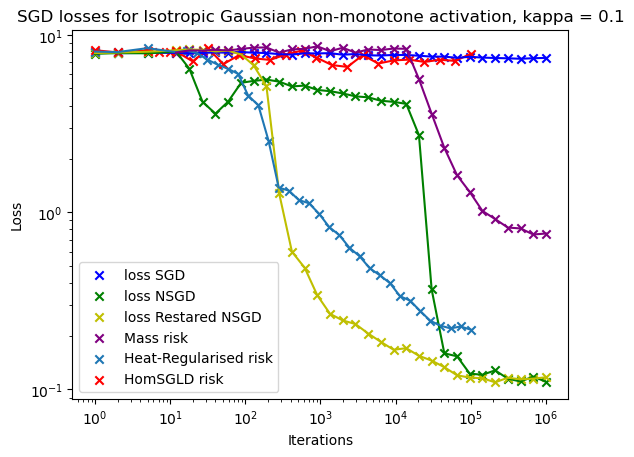

In [195]:
#plot SGD losses vs Nesterov accelerated SGD losses
indices = [1,2,5]+[int(a) for a in 10**(np.linspace(1.1, int(np.log10(1e6)), 30))]
indices_heat = [1,2,5]+[int(a) for a in 10**(np.linspace(1.1, int(np.log10(1e5)), 30))]
indices_hom = [1,2,5,7,10]+[int(a) for a in 10**(np.linspace(1.1, np.log10(1e5), 20))]
indices_Mass = [int(a) for a in 10**(np.linspace(1.1, np.log10(1e6), 30))]

fig, ax = plt.subplots()
ax.plot(indices_hom, risk_HomSGLD, c = 'r')
ax.plot(indices, risk_1, c = 'b')
ax.plot(indices, risk_NSGD, c = 'g')
ax.plot(indices, risk_RNSGD, c = 'y')
ax.plot(indices_heat, risk_HeatSGD)
plt.plot(indices_Mass, risk_Mass, c = 'purple')

ax.scatter(indices, risk_1, marker = 'x', c = 'b', label = 'loss SGD')
ax.scatter(indices, risk_NSGD, marker = 'x', c = 'g', label = 'loss NSGD')
ax.scatter(indices, risk_RNSGD, marker = 'x', c = 'y', label = 'loss Restared NSGD')
plt.scatter(indices_Mass, risk_Mass, marker = 'x', c = 'purple', label = 'Mass risk')
ax.scatter(indices_heat, risk_HeatSGD, marker = 'x', label = 'Heat-Regularised risk')
ax.scatter(indices_hom, risk_HomSGLD, marker = 'x', label = 'HomSGLD risk', c = 'r')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('SGD losses for Isotropic Gaussian non-monotone activation, kappa = 0.1')
ax.legend()
plt.show()

In [37]:
from scipy.stats import norm

def q_plus(t, Delta):
    if t>0.01:
        x = np.linspace(0, 1.5/((1+Delta)*t), 1000)
        f = 1 / (np.sqrt(2 * np.pi)) * vsigma_nm((1 + Delta) * t * x) * np.exp(-x ** 2 / 2)
        integral = np.trapz(f, x)
        return integral -2.5*0.5+7.5*(1-norm.cdf(1.5/((1+Delta)*t)))
    else:
        g = np.random.normal(0,1,100)
        return np.mean(vsigma_nm((1+Delta)*t*g))

def q_minus(t, Delta):
    if t > 0.01:
        x = np.linspace(0, 1.5/((1-Delta)*t), 1000)
        f = 1 / (np.sqrt(2 * np.pi)) * vsigma_nm((1 - Delta) * t * x) * np.exp(-x ** 2 / 2)
        integral = np.trapz(f, x)
        return integral -2.5*0.5+7.5*(1-norm.cdf(1.5/((1-Delta)*t)))
    else:
        g = np.random.normal(0,1,100)
        return np.mean(vsigma_nm((1-Delta)*t*g))
    #return integral

vq_plus = np.vectorize(q_plus)
vq_minus = np.vectorize(q_minus)

def dq_plus(t, Delta):
    x1 = np.linspace(0, 0.5/((1+Delta)*t), 100)
    f1 = (1+Delta) / (np.sqrt(2 * np.pi)) * (-4+2.5)/(0.5) * np.exp(-x1 ** 2 / 2)*x1
    integral1 = np.trapz(f1, x1)
    x2 = np.linspace(0.5/((1+Delta)*t), 1.5/((1+Delta)*t), 100)
    f2 = (1+Delta) / (np.sqrt(2 * np.pi)) * 11.5 * np.exp(-x2 ** 2 / 2)*x2
    integral2 = np.trapz(f2, x2)
    return integral1+integral2

def dq_minus(t, Delta):
    x1 = np.linspace(0, 0.5/((1-Delta)*t), 100)
    f1 = (1-Delta) / (np.sqrt(2 * np.pi)) * (-4+2.5)/(0.5) * np.exp(-x1 ** 2 / 2)*x1
    integral1 = np.trapz(f1, x1)
    x2 = np.linspace(0.5/((1-Delta)*t), 1.5/((1-Delta)*t), 100)
    f2 = (1-Delta) / (np.sqrt(2 * np.pi)) * 11.5 * np.exp(-x2 ** 2 / 2)*x2
    integral2 = np.trapz(f2, x2)
    return integral1+integral2
    
vdq_plus = np.vectorize(dq_plus)
vdq_minus = np.vectorize(dq_minus)

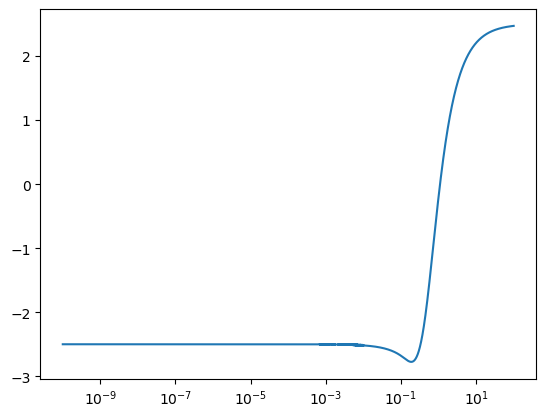

In [38]:
epsilon = 1e-5
Delta = 0.5
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_plus_vals = vq_plus(Interval_q, Delta)
plt.plot(Interval_q, q_plus_vals)
plt.xscale('log')

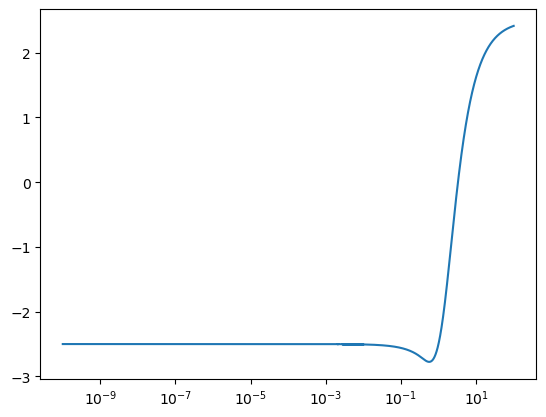

In [39]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
q_minus_vals = vq_minus(Interval_q, Delta)
plt.plot(Interval_q, q_minus_vals)
plt.xscale('log')

In [40]:
Q_plus = dict(zip(Interval_q, q_plus_vals))
Q_minus = dict(zip(Interval_q, q_minus_vals))

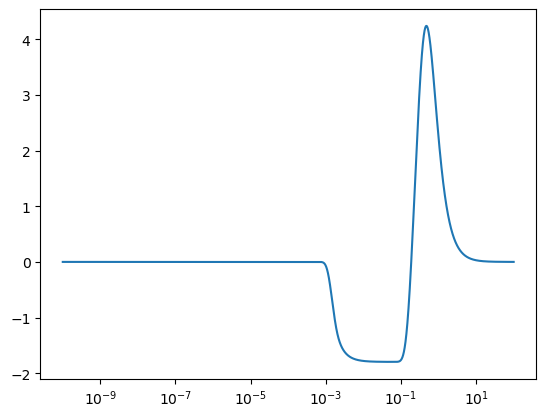

In [41]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_plus_vals = vdq_plus(Interval_q, Delta)
plt.plot(Interval_q, dq_plus_vals)
plt.xscale('log')

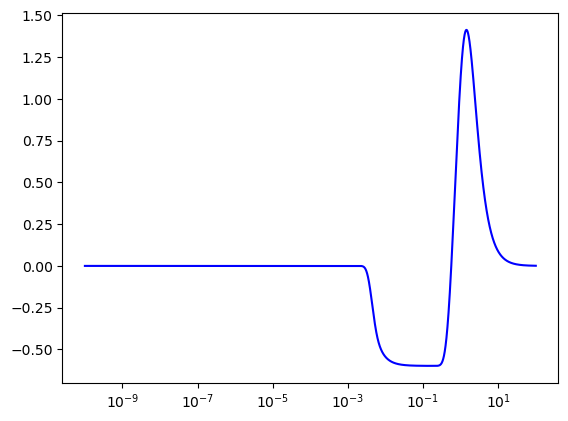

In [42]:
Interval_q = 10**np.linspace(-10,np.log10(epsilon*1e7), int(1e5))
dq_minus_vals = vdq_minus(Interval_q, Delta)
plt.plot(Interval_q, dq_minus_vals, c = 'b')
plt.xscale('log')

In [43]:
dQ_plus = dict(zip(Interval_q, dq_plus_vals))
dQ_minus = dict(zip(Interval_q, dq_minus_vals))

In [44]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
vfind_nearest = np.vectorize(find_nearest)

In [45]:
def q_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_plus[r_approx]

def q_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return Q_minus[r_approx]

vq_plus_new = np.vectorize(q_plus_new)
vq_minus_new = np.vectorize(q_minus_new)

def dq_plus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_plus[r_approx]

def dq_minus_new(r):
    r_approx = find_nearest(Interval_q, r)
    return dQ_minus[r_approx]

vdq_plus_new = np.vectorize(dq_plus_new)
vdq_minus_new = np.vectorize(dq_minus_new)


def R_inf(vq_plus, vq_minus, Delta):
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return 0.5 * (1 - mean_vq_plus) ** 2 + 0.5 * (1 + mean_vq_minus) ** 2

def grad_R_inf(r, vq_plus, vq_minus, dplus, dminus, Delta):
    J = len(r)
    mean_vq_plus = np.mean(vq_plus)
    mean_vq_minus = np.mean(vq_minus)
    return -1 / J * dplus * (1 - mean_vq_plus) + 1 / J * dminus * (1 + mean_vq_minus)

def update(r, dt, grad):
    J = len(r)
    return J * grad * dt

In [46]:
#simulate pde
def pde_sim(kappa, d, J, epsilon = 1e-5, Delta = 0.5):
    """
    Simulate a partial differential equation (PDE) using a specified configuration.

    Parameters:
        kappa (float): A parameter controlling the spread of the PDE.
        d (int): The dimensionality of the PDE.
        J (int): The number of processes.
        epsilon (float, optional): The learning rate. Default is 1e-5.
        Delta (float, optional): A parameter controlling the spread of the PDE. Default is 0.5.

    Returns:
        tuple: A tuple containing the following elements:
            - risk (numpy.ndarray): The risk at each simulation step.
            - mean_dist (list): The mean distance at each simulation step.
    """
    Interval = 10**np.linspace(-10, np.log10(epsilon*1e7), int(1e5))
    separations = [Interval[k+1]-Interval[k] for k in range(len(Interval)-1)]
    processes_count = 4
    risk = np.zeros(Interval.shape[0])
    Z = np.random.multivariate_normal([0]*d, np.diag([(kappa)**2/d]*d), J).reshape(J, d)
    r = np.linalg.norm(Z, axis = 1)
    mean_dist = []
    for k in trange(len(separations)):
        dt = separations[k]
        plus = vq_plus(r, Delta)
        minus = vq_minus(r, Delta)
        dplus = vdq_plus(r, Delta)
        dminus = vdq_minus(r, Delta)
        '''
        output = parallelise(r).reshape(4,J)
        plus = output[0]
        minus = output[1]
        dplus = output[2]
        dminus = output[3]
        '''
        inf_risk = R_inf(plus, minus, Delta)
        risk[k] = inf_risk
        d = np.mean(r)
        mean_dist.append(d)
        print('Epoch: {}, risk: {}'.format(k, inf_risk))
        grad = grad_R_inf(r, plus, minus, dplus, dminus, Delta)
        r = r - (Interval[k])**(-0.25)*update(r,dt, grad)
    plus = vq_plus(r, Delta)
    minus = vq_minus(r, Delta)
    inf_risk = R_inf(plus, minus, Delta)
    risk[-1] = inf_risk
    mean_dist.append(np.mean(r))
    return risk, mean_dist

In [96]:
#SGD run
d = 32
N = 800
Delta = 0.5

weights_1,risk_1, mean_dist_sgd_1, indices = stochastic_gradient_descent(d, Delta, N, 0.1, epsilon = (1e-5), num_epochs = int(1e3))
weights_4,risk_4, mean_dist_sgd_4, indices = stochastic_gradient_descent(d, Delta, N, 0.4, epsilon = (1e-5), num_epochs = int(1e3))

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1, risk: 8.025949439176298
Epoch: 2, risk: 7.897928759015991
Epoch: 5, risk: 7.929990728872767
Epoch: 12, risk: 7.940381056320942
Epoch: 14, risk: 7.893342270200548
Epoch: 17, risk: 7.925041764907702
Epoch: 19, risk: 7.977404631414163
Epoch: 23, risk: 7.954690090631324
Epoch: 26, risk: 8.01302267246325
Epoch: 31, risk: 7.950902423358087
Epoch: 36, risk: 7.915632281843133
Epoch: 42, risk: 7.8029273826329515
Epoch: 48, risk: 7.7568152969018005
Epoch: 56, risk: 7.888306890403961
Epoch: 66, risk: 7.874648746995864
Epoch: 76, risk: 7.904175752193261
Epoch: 89, risk: 7.741051182219767
Epoch: 104, risk: 7.817399628372754
Epoch: 120, risk: 7.681818610327573
Epoch: 140, risk: 7.663973107902148
Epoch: 163, risk: 7.719418536981034
Epoch: 190, risk: 7.711251036194073
Epoch: 221, risk: 7.647838214420847
Epoch: 257, risk: 7.552312398989319
Epoch: 299, risk: 7.55665404138186
Epoch: 347, risk: 7.4326230748176645
Epoch: 404, risk: 7.539066876696033
Epoch: 470, risk: 7.4595997180643785
Epoch: 546

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 1, risk: 6.706249882314296
Epoch: 2, risk: 6.742390119408863
Epoch: 5, risk: 6.661803676800156
Epoch: 12, risk: 6.612816264953435
Epoch: 14, risk: 6.629128225996584
Epoch: 17, risk: 6.62014889248305
Epoch: 19, risk: 6.446211713028344
Epoch: 23, risk: 6.408274237272544
Epoch: 26, risk: 6.44335092869528
Epoch: 31, risk: 6.334679864225371
Epoch: 36, risk: 6.252680835653334
Epoch: 42, risk: 6.1883262650091035
Epoch: 48, risk: 6.1134902901436465
Epoch: 56, risk: 6.0387331500784
Epoch: 66, risk: 5.931378663671622
Epoch: 76, risk: 5.862119148665948
Epoch: 89, risk: 5.788787231384433
Epoch: 104, risk: 5.641358394281156
Epoch: 120, risk: 5.476952699608804
Epoch: 140, risk: 5.470249159901323
Epoch: 163, risk: 5.3829896255067595
Epoch: 190, risk: 5.25172514027936
Epoch: 221, risk: 5.06952973233872
Epoch: 257, risk: 4.883698449589893
Epoch: 299, risk: 4.678746779104918
Epoch: 347, risk: 4.537454612741356
Epoch: 404, risk: 4.31525439327701
Epoch: 470, risk: 4.091486389817975
Epoch: 546, risk

In [91]:
pde_risk_1, mean_dist_pde_1 = pde_sim(0.1, 320, 1, epsilon = 1e-5, Delta = 0.5)
pde_risk_4, mean_dist_pde_4 = pde_sim(0.4, 320, 1, epsilon = 1e-5, Delta = 0.5)

In [97]:
epsilon = 1e-5
Interval = 10**np.linspace(-10, np.log10(epsilon*1e7), int(1e5))

discretised_pde_1 = lambda k: pde_risk_1[np.abs(Interval - epsilon**(4/4)*k).argmin()]
disc_pde_loss_1 = np.vectorize(discretised_pde_1)

avg_dist_pde_1 = lambda k: mean_dist_pde_1[np.abs(Interval - epsilon**(4/4)*k).argmin()]
avg_dist_pde_1 = np.vectorize(avg_dist_pde_1)

discretised_pde_4 = lambda k: pde_risk_4[np.abs(Interval - epsilon**(4/4)*k).argmin()]
disc_pde_loss_4 = np.vectorize(discretised_pde_4)

avg_dist_pde_4 = lambda k: mean_dist_pde_4[np.abs(Interval - epsilon**(4/4)*k).argmin()]
avg_dist_pde_4 = np.vectorize(avg_dist_pde_4)

iters = np.arange(1, int(1e4)+1)
indices = [1,2,5]+[int(a) for a in 10**(np.linspace(1.1, 3, 30))]

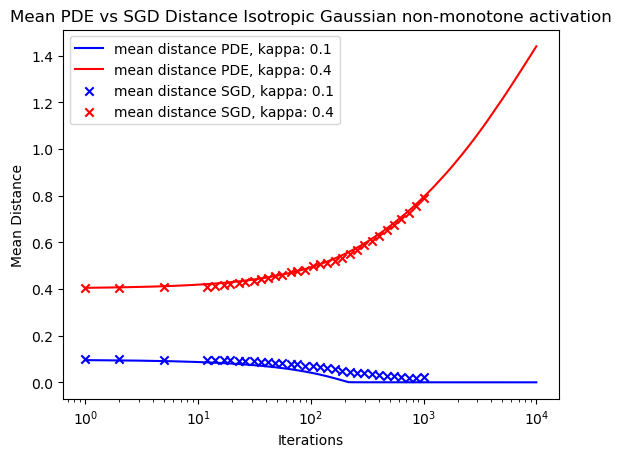

In [98]:
#plot mean distance of network parameters and PDE particles
fig, ax = plt.subplots()
ax.plot(iters, avg_dist_pde_1(iters), c = 'b', label = 'mean distance PDE, kappa: 0.1')
ax.plot(iters, avg_dist_pde_4(iters), c = 'r', label = 'mean distance PDE, kappa: 0.4')
ax.scatter(indices, mean_dist_sgd_1, marker = 'x', c = 'b', label = 'mean distance SGD, kappa: 0.1')
ax.scatter(indices, mean_dist_sgd_4, marker = 'x', c = 'r', label = 'mean distance SGD, kappa: 0.4')
ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Mean Distance')
ax.set_title('Mean PDE vs SGD Distance Isotropic Gaussian non-monotone activation')
ax.legend()
plt.show()

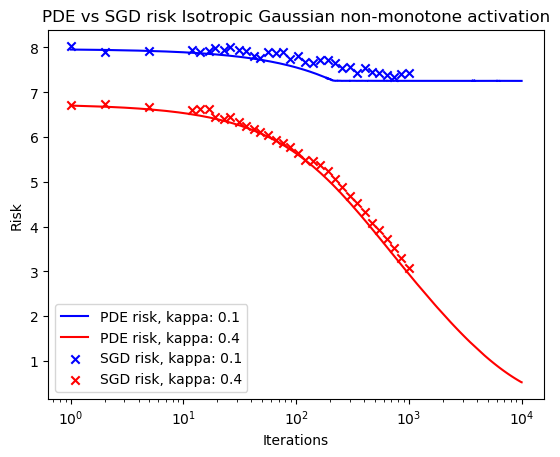

In [99]:
#plot mean risk of network parameters and PDE particles
fig, ax = plt.subplots()
ax.plot(iters, disc_pde_loss_1(iters), c = 'b', label = 'PDE risk, kappa: 0.1')
ax.plot(iters, disc_pde_loss_4(iters), c = 'r', label = 'PDE risk, kappa: 0.4')
ax.scatter(indices, risk_1, marker = 'x', c = 'b', label = 'SGD risk, kappa: 0.1')
ax.scatter(indices, risk_4, marker = 'x', c = 'r', label = 'SGD risk, kappa: 0.4')
ax.set_xscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Risk')
ax.set_title('PDE vs SGD risk Isotropic Gaussian non-monotone activation')
ax.legend()
plt.show()

# General Observations

- The losses and parameter values observed during the SGD run matches relatively closely the respective values obtained by the distributional dynamics as expected, bearing in mind that the dimensionality of the problem was reduced by a factor of ten to speed up computations
- The non-monotone activation function in the neural network introduced some non-global minima where SGD seemed to get stuck, whereas Nesterov SGD seemed to avoid such ‘bad minima’ and attain monotonically decreasing losses characteristic of a global minimum. MF-HomSGLD seems to take longer to converge, maybe the hyper-parameters of the algorithm are not optimally tuned. 
- Furthermore, gradient restarted Nesterov SGD mentioned in the 2015 paper by Candes et al. entitled 'A Differential Equation for Modeling Nesterov’s Accelerated Gradient Method: Theory and Insights' beats Nesterov accelerated SGD with constant momentum 
- The MaSS algorithm seems to outperform the Nesterov accelerated sgd only in later iterations